In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import colors
from matplotlib.widgets import Slider
import matplotlib
import matplotlib.font_manager

from medmnist import VesselMNIST3D
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())

TensorFlow version: 2.20.0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [16]:
train_dataset = VesselMNIST3D(split='train', size=28, download=True)
trainx = []
trainy = []

test_dataset = VesselMNIST3D(split='test', size=28, download=True)
testx = []
testy = []

val_dataset = VesselMNIST3D(split='val', size=28, download=True)  # Fixed: was 'train'
valx = []
valy = []

for i in range(len(train_dataset)):
    trainx.append(train_dataset[i][0])
    trainy.append(train_dataset[i][1])

for i in range(len(test_dataset)):
    testx.append(test_dataset[i][0])
    testy.append(test_dataset[i][1])

for i in range(len(val_dataset)):
    valx.append(val_dataset[i][0])
    valy.append(val_dataset[i][1])

trainx_tensor = tf.convert_to_tensor(trainx, dtype=tf.float32)  # Using float32 for now
trainy_tensor = tf.convert_to_tensor(trainy, dtype=tf.float32)
testx_tensor = tf.convert_to_tensor(testx, dtype=tf.float32)
testy_tensor = tf.convert_to_tensor(testy, dtype=tf.float32)
valx_tensor = tf.convert_to_tensor(valx, dtype=tf.float32)
valy_tensor = tf.convert_to_tensor(valy, dtype=tf.float32)

print(f"\nData loaded successfully!")
print(f"Training set: {trainx_tensor.shape}")
print(f"Validation set: {valx_tensor.shape}")
print(f"Test set: {testx_tensor.shape}")



Data loaded successfully!
Training set: (1335, 1, 28, 28, 28)
Validation set: (191, 1, 28, 28, 28)
Test set: (382, 1, 28, 28, 28)


Training - Class 0 (Healthy): 1185, Class 1 (Aneurysm): 150
Validation - Class 0 (Healthy): 169, Class 1 (Aneurysm): 22
Test - Class 0 (Healthy): 339, Class 1 (Aneurysm): 43

Class imbalance ratio (train): 0.127


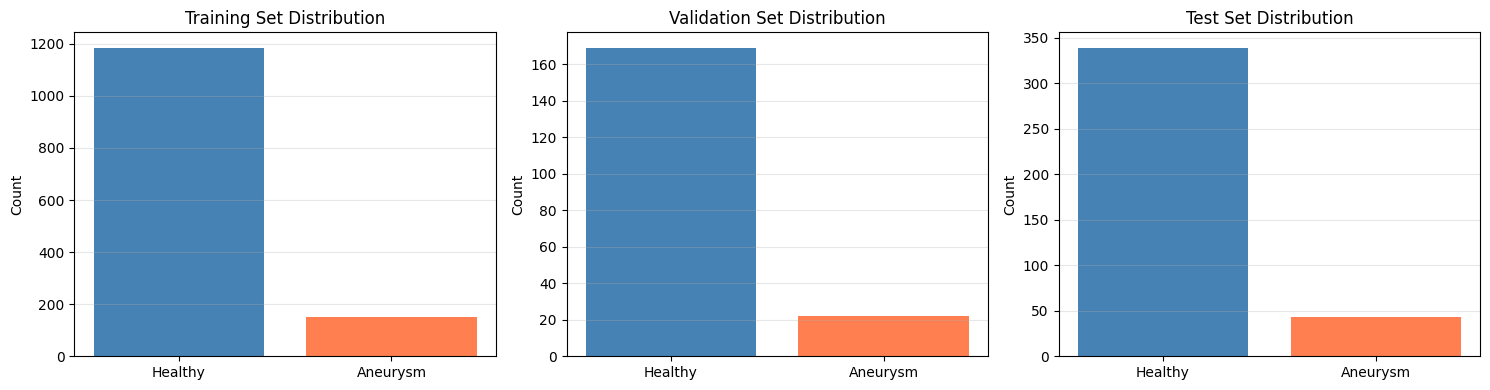

In [3]:
# Analyze class distribution
train_labels = np.array(trainy).flatten()
val_labels = np.array(valy).flatten()
test_labels = np.array(testy).flatten()

unique_train, counts_train = np.unique(train_labels, return_counts=True)
unique_val, counts_val = np.unique(val_labels, return_counts=True)
unique_test, counts_test = np.unique(test_labels, return_counts=True)

print(f"Training - Class 0 (Healthy): {counts_train[0]}, Class 1 (Aneurysm): {counts_train[1]}")
print(f"Validation - Class 0 (Healthy): {counts_val[0]}, Class 1 (Aneurysm): {counts_val[1]}")
print(f"Test - Class 0 (Healthy): {counts_test[0]}, Class 1 (Aneurysm): {counts_test[1]}")
print(f"\nClass imbalance ratio (train): {counts_train[1]/counts_train[0]:.3f}")

# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, counts) in zip(axes, 
    [('Training', counts_train), ('Validation', counts_val), ('Test', counts_test)]):
    ax.bar(['Healthy', 'Aneurysm'], counts, color=['steelblue', 'coral'])
    ax.set_ylabel('Count')
    ax.set_title(f'{name} Set Distribution')
    ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

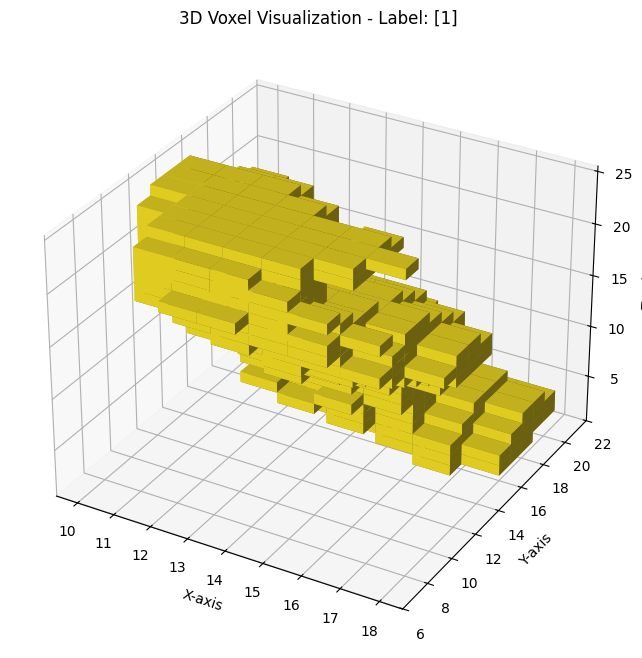

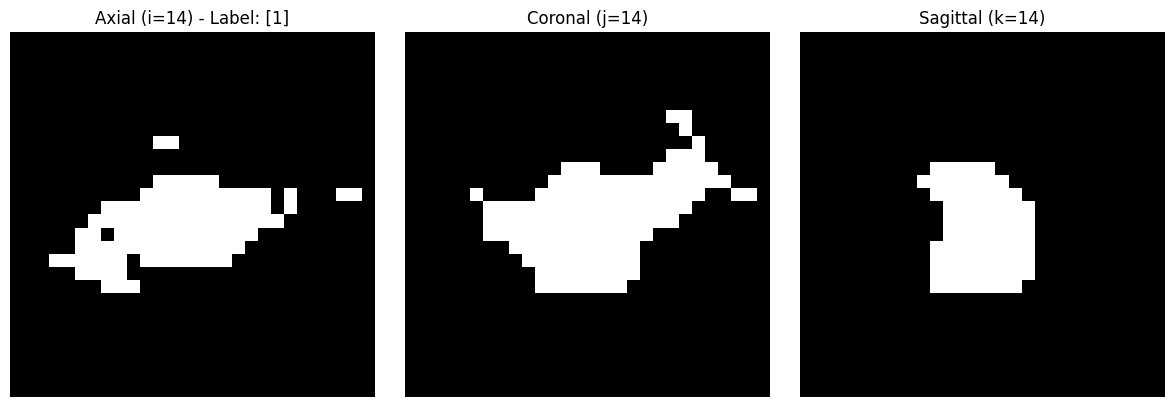

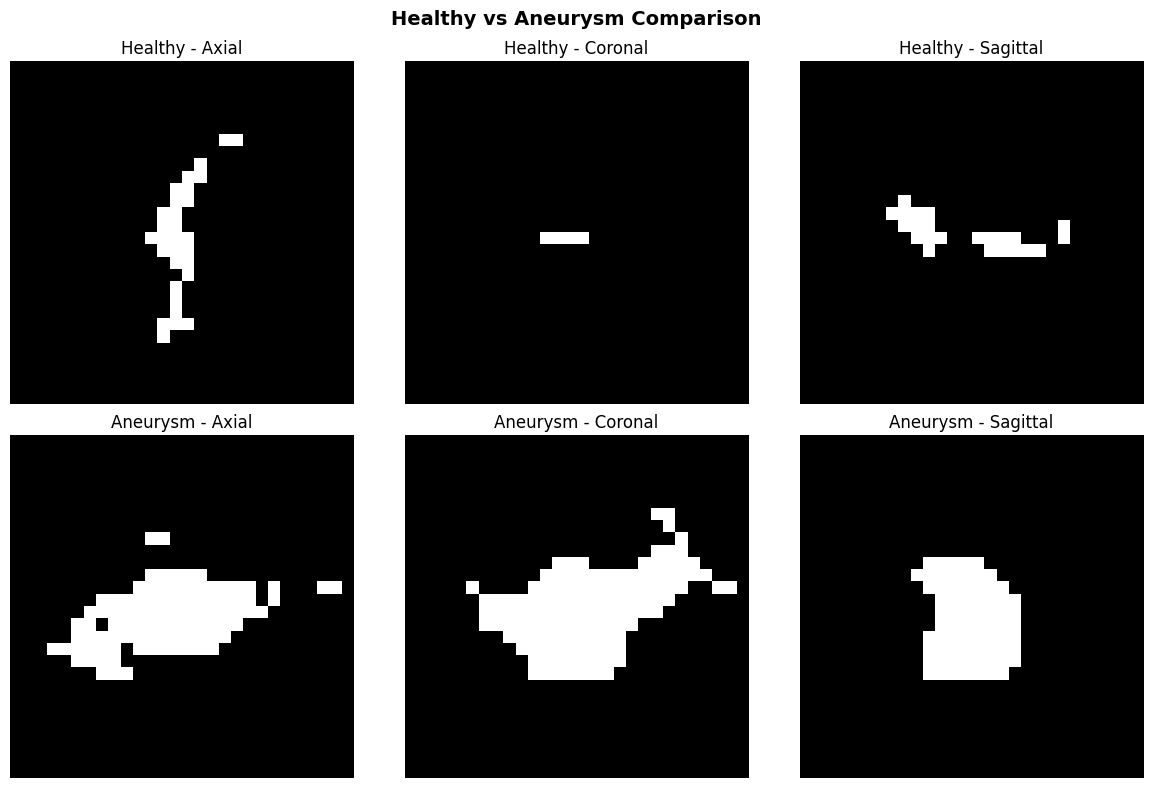

In [30]:
# Example 1: 3D Voxel Visualization
fig = plt.figure(figsize=(10, 8))
vol = np.squeeze(trainx[1], axis=0)  # shape (28, 28, 28)
ax = fig.add_subplot(111, projection='3d')

filled = vol > 0
norm = colors.Normalize(vmin=vol.min(), vmax=vol.max())
cmap = plt.cm.viridis
facecolors = cmap(norm(vol))
alpha = np.clip(vol, 0, 1)
facecolors[..., 3] = alpha
facecolors[~filled, 3] = 0.0

ax.voxels(filled, facecolors=facecolors)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.title(f'3D Voxel Visualization - Label: {trainy[1]}')
plt.show()

# Example 2: Orthogonal Slices (Middle Slices)
vol = np.array(trainx[0]).squeeze()
i_mid = vol.shape[0] // 2
j_mid = vol.shape[1] // 2
k_mid = vol.shape[2] // 2

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(vol[i_mid, :, :], cmap='gray')
axes[0].set_title(f'Axial (i={i_mid}) - Label: {trainy[0]}')
axes[0].axis('off')

axes[1].imshow(vol[:, j_mid, :], cmap='gray')
axes[1].set_title(f'Coronal (j={j_mid})')
axes[1].axis('off')

axes[2].imshow(vol[:, :, k_mid], cmap='gray')
axes[2].set_title(f'Sagittal (k={k_mid})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Example 3: Show healthy vs aneurysm examples
healthy_idx = np.where(train_labels == 0)[0][0]
aneurysm_idx = np.where(train_labels == 1)[0][0]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Healthy vs Aneurysm Comparison', fontsize=14, fontweight='bold')

# Healthy example
vol_healthy = np.array(trainx[healthy_idx]).squeeze()
mid = vol_healthy.shape[0] // 2
axes[0, 0].imshow(vol_healthy[mid, :, :], cmap='gray')
axes[0, 0].set_title('Healthy - Axial')
axes[0, 0].axis('off')
axes[0, 1].imshow(vol_healthy[:, mid, :], cmap='gray')
axes[0, 1].set_title('Healthy - Coronal')
axes[0, 1].axis('off')
axes[0, 2].imshow(vol_healthy[:, :, mid], cmap='gray')
axes[0, 2].set_title('Healthy - Sagittal')
axes[0, 2].axis('off')

# Aneurysm example
vol_aneurysm = np.array(trainx[aneurysm_idx]).squeeze()
mid = vol_aneurysm.shape[0] // 2
axes[1, 0].imshow(vol_aneurysm[mid, :, :], cmap='gray')
axes[1, 0].set_title('Aneurysm - Axial')
axes[1, 0].axis('off')
axes[1, 1].imshow(vol_aneurysm[:, mid, :], cmap='gray')
axes[1, 1].set_title('Aneurysm - Coronal')
axes[1, 1].axis('off')
axes[1, 2].imshow(vol_aneurysm[:, :, mid], cmap='gray')
axes[1, 2].set_title('Aneurysm - Sagittal')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# From (1335, 1, 28, 28, 28) to (1335, 28, 28, 28, 1)
trainx_tensor = tf.transpose(trainx_tensor, [0, 2, 3, 4, 1])
valx_tensor = tf.transpose(valx_tensor, [0, 2, 3, 4, 1])
testx_tensor = tf.transpose(testx_tensor, [0, 2, 3, 4, 1])

print(f"After transpose - Training data shape: {trainx_tensor.shape}")

# Normalize data to [0, 1] range
trainx_norm = trainx_tensor / 255.0
valx_norm = valx_tensor / 255.0
testx_norm = testx_tensor / 255.0

# Flatten labels
trainy_flat = tf.squeeze(trainy_tensor)
valy_flat = tf.squeeze(valy_tensor)
testy_flat = tf.squeeze(testy_tensor)

print(f"Normalized training data shape: {trainx_norm.shape}")
print(f"Training labels shape: {trainy_flat.shape}")
print(f"Data range: [{tf.reduce_min(trainx_norm):.3f}, {tf.reduce_max(trainx_norm):.3f}]")

# Calculate class weights for imbalanced data
class_weight = {
    0: len(train_labels) / (2 * counts_train[0]),
    1: len(train_labels) / (2 * counts_train[1])
}
print(f"\nClass weights to handle imbalance: {class_weight}")

After transpose - Training data shape: (1335, 28, 28, 28, 1)
Normalized training data shape: (1335, 28, 28, 28, 1)
Training labels shape: (1335,)
Data range: [0.000, 0.004]

Class weights to handle imbalance: {0: np.float64(0.5632911392405063), 1: np.float64(4.45)}


In [18]:

"""
Architecture Design Rationale:
- 3D Convolutional layers to capture spatial relationships in volumetric data
- Progressive downsampling (28→14→7→3) to build hierarchical features
- Batch normalization for training stability
- Dropout for regularization (critical for small dataset)
- Dense layers for final classification
- Sigmoid activation for binary classification

The architecture processes the 3D volume through multiple convolutional blocks,
each extracting increasingly abstract features before making a classification.
"""

def build_3d_cnn(input_shape=(28, 28, 28, 1), dropout_rate=0.3):
    """
    Build a 3D CNN for binary classification of vessel segments
    
    Parameters:
    - input_shape: Shape of input 3D volume with channel
    - dropout_rate: Dropout probability for regularization
    
    Returns:
    - Compiled Keras model
    """
    
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Block 1: Initial feature extraction (28x28x28 → 14x14x14)
        layers.Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Dropout(dropout_rate),
        
        # Block 2: Deeper features (14x14x14 → 7x7x7)
        layers.Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Dropout(dropout_rate),
        
        # Block 3: High-level features (7x7x7 → 3x3x3)
        layers.Conv3D(128, kernel_size=(3, 3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Dropout(dropout_rate),
        
        # Global pooling to reduce parameters
        layers.GlobalAveragePooling3D(),
        
        # Dense layers for classification
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        
        # Output layer (sigmoid for binary classification)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Build and display model
model = build_3d_cnn(input_shape=(28, 28, 28, 1), dropout_rate=0.3)
model.summary()

print("\nTotal parameters:", model.count_params())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)               │ (None, 28, 28, 28, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 28, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 14, 14, 14, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 14, 14, 14, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 14, 14, 14, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 14, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 7, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 7, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 7, 7, 7, 128)   │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 7, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 3, 3, 3, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 3, 3, 3, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,001 (1.25 MB)

 Trainable params: 327,553 (1.25 MB)

 Non-trainable params: 448 (1.75 KB)


Total parameters: 328001


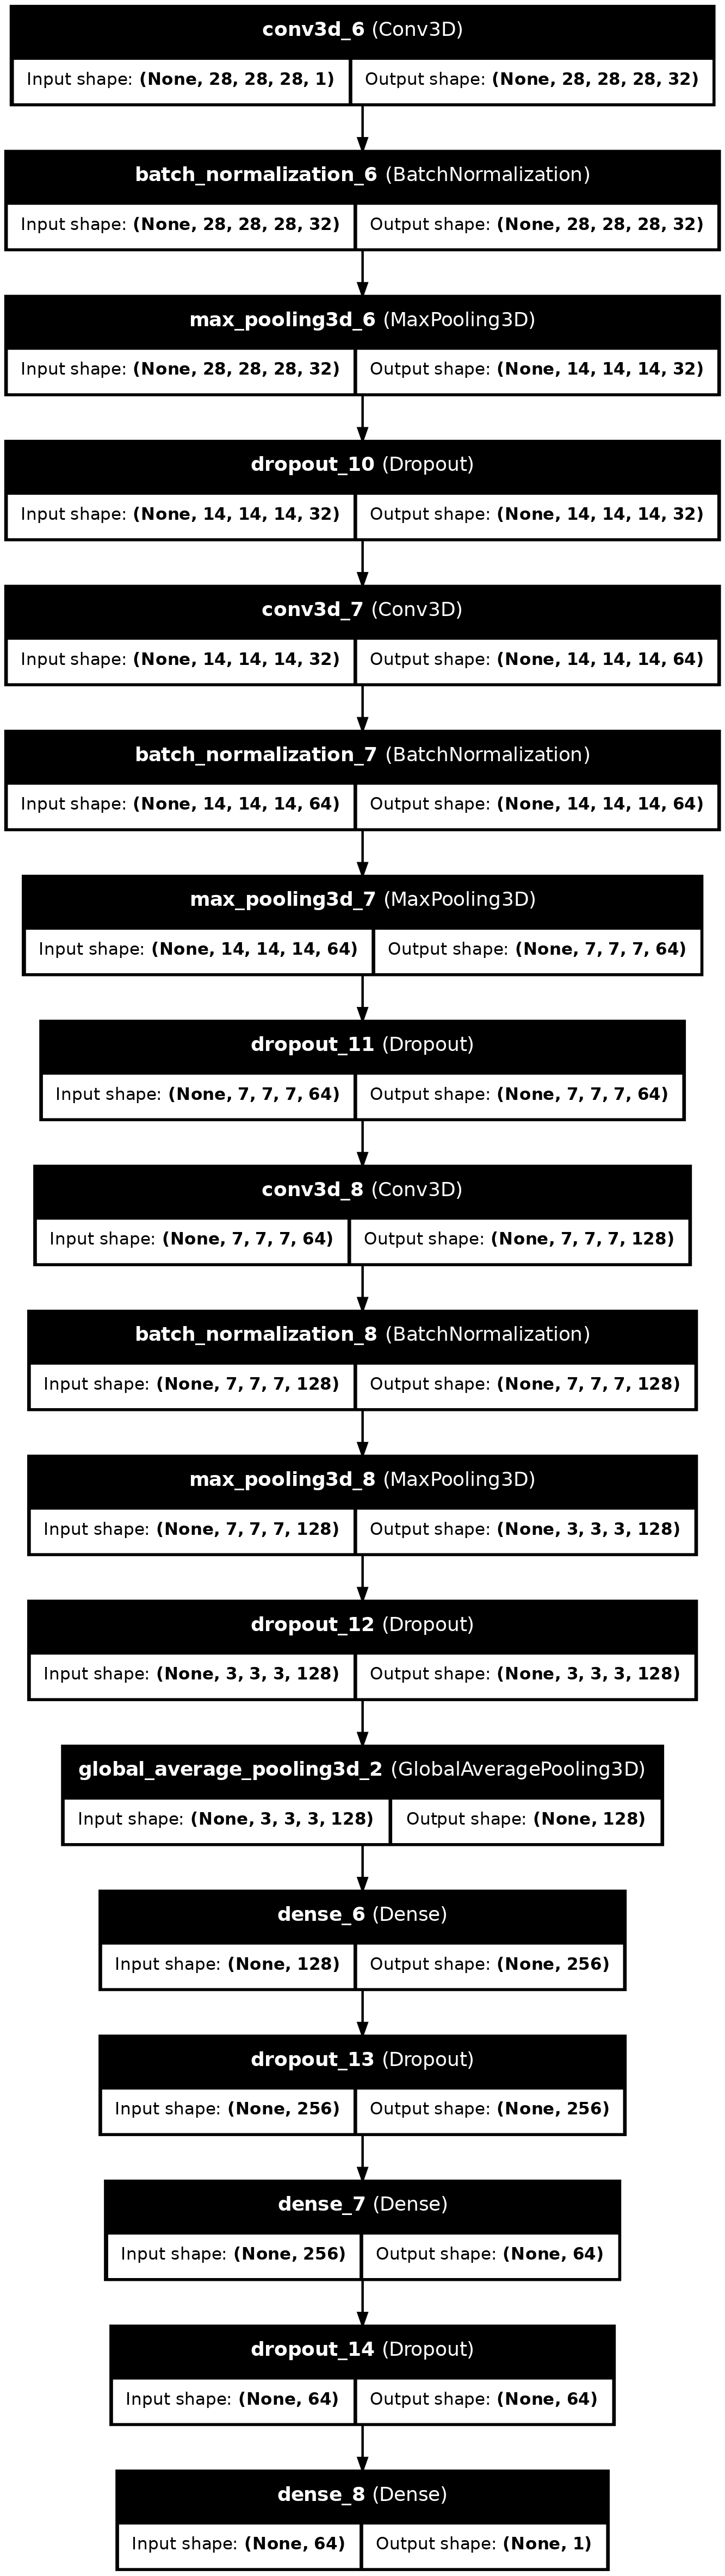

In [29]:
plot_model(
    model,
    to_file="3d_cnn_architecture.png",
    show_shapes=True,        # show tensor shapes
    show_layer_names=True,   # show layer names (Conv3D, Dense, etc.)
    dpi=160,                 # higher resolution
    expand_nested=False
)

In [19]:
"""
Loss Function: Binary Crossentropy
- Standard for binary classification tasks
- Measures difference between predicted and actual probabilities

Optimizer: Adam
- Adaptive learning rate optimizer
- Works well with default parameters for most problems

Metrics:
- Accuracy: Overall correctness
- AUC: Area Under ROC Curve - crucial for imbalanced medical datasets
  Measures the model's ability to distinguish between classes
"""

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

print("Model compiled with:")
print("- Optimizer: Adam (lr=0.001)")
print("- Loss: Binary Crossentropy")
print("- Metrics: Accuracy, AUC")


Model compiled with:
- Optimizer: Adam (lr=0.001)
- Loss: Binary Crossentropy
- Metrics: Accuracy, AUC


In [20]:

# Early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=15,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

# Reduce learning rate when validation loss plateaus
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Save best model
checkpoint = keras.callbacks.ModelCheckpoint(
    'best_vessel_model.h5',
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=1
)

print("\nCallbacks configured:")
print("- Early Stopping: patience=15, monitor=val_auc")
print("- ReduceLROnPlateau: factor=0.5, patience=5")
print("- ModelCheckpoint: saves best val_auc")



Callbacks configured:
- Early Stopping: patience=15, monitor=val_auc
- ReduceLROnPlateau: factor=0.5, patience=5
- ModelCheckpoint: saves best val_auc


In [21]:
# Train for 2 epochs to confirm the model is working
history = model.fit(
    trainx_norm, trainy_flat,
    batch_size=16,
    epochs=2,
    validation_data=(valx_norm, valy_flat),
    class_weight=class_weight,
    verbose=1
)

print("\n" + "="*70)
print("INITIAL TEST RESULTS")
print("="*70)
print(f"Epoch 1 → Training Loss: {history.history['loss'][0]:.4f}, "
      f"Val Loss: {history.history['val_loss'][0]:.4f}")
print(f"Epoch 2 → Training Loss: {history.history['loss'][1]:.4f}, "
      f"Val Loss: {history.history['val_loss'][1]:.4f}")
print(f"\nTraining AUC: {history.history['auc'][-1]:.4f}")
print(f"Validation AUC: {history.history['val_auc'][-1]:.4f}")

# Check if loss is decreasing (sign of learning)
if history.history['loss'][1] < history.history['loss'][0]:
    print("\n Loss is decreasing - model is learning!")
else:
    print("\n Loss not decreasing - may need to adjust hyperparameters")


Epoch 1/2


2025-12-12 08:59:06.066704: I external/local_xla/xla/service/service.cc:163] XLA service 0x7133a80079e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-12 08:59:06.066722: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-12-12 08:59:06.066728: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-12-12 08:59:06.113137: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-12 08:59:06.412382: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4782 - auc: 0.4689 - loss: 0.9894

I0000 00:00:1765547950.402087 2982702 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5184 - auc: 0.5132 - loss: 0.8908

2025-12-12 08:59:15.093718: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_170', 8 bytes spill stores, 8 bytes spill loads

2025-12-12 08:59:15.861553: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_170', 8 bytes spill stores, 8 bytes spill loads



84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.5805 - auc: 0.5877 - loss: 0.7441 - val_accuracy: 0.8848 - val_auc: 0.5000 - val_loss: 0.5807
Epoch 2/2
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5498 - auc: 0.6828 - loss: 0.6272 - val_accuracy: 0.8848 - val_auc: 0.5059 - val_loss: 0.4159

INITIAL TEST RESULTS
Epoch 1 → Training Loss: 0.7441, Val Loss: 0.5807
Epoch 2 → Training Loss: 0.6272, Val Loss: 0.4159

Training AUC: 0.6828
Validation AUC: 0.5059

 Loss is decreasing - model is learning!


Starting full training session...
Epoch 1/100


2025-12-12 08:59:36.602141: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-12 08:59:36.602167: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-12 08:59:36.602181: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-12 08:59:36.602189: I external/l

37/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5995 - auc: 0.7149 - loss: 0.6115

2025-12-12 08:59:42.038522: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-12 08:59:42.038543: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-12 08:59:42.038551: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-12 08:59:42.038559: I external/l

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6008 - auc: 0.7155 - loss: 0.6103

2025-12-12 08:59:46.478475: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-12 08:59:46.668499: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_170', 8 bytes spill stores, 8 bytes spill loads

2025-12-12 08:59:47.660853: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-12 08:59:47.660875: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filte


Epoch 1: val_auc improved from None to 0.54250, saving model to best_vessel_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - accuracy: 0.6082 - auc: 0.7216 - loss: 0.6006 - val_accuracy: 0.8848 - val_auc: 0.5425 - val_loss: 0.3896 - learning_rate: 0.0010
Epoch 2/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6403 - auc: 0.7901 - loss: 0.5576
Epoch 2: val_auc improved from 0.54250 to 0.57195, saving model to best_vessel_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6240 - auc: 0.7663 - loss: 0.5603 - val_accuracy: 0.8848 - val_auc: 0.5719 - val_loss: 0.3731 - learning_rate: 0.0010
Epoch 3/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6578 - auc: 0.8273 - loss: 0.5145
Epoch 3: val_auc did not improve from 0.57195
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6255 - auc: 0.7958 - loss: 0.5408 - val_accuracy: 0.8848 - val_auc: 0.4866 - val_loss: 0.3673 - learning_rate: 0.0010
Epoch 4/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6979 - auc: 0.8429 - loss: 0.4879
Epoch 4: val_auc improved from 0.57195 to 0.75807, saving model to best_vessel_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6959 - auc: 0.8277 - loss: 0.4915 - val_accuracy: 0.8848 - val_auc: 0.7581 - val_loss: 0.3551 - learning_rate: 0.0010
Epoch 5/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7164 - auc: 0.8297 - loss: 0.5178
Epoch 5: val_auc improved from 0.75807 to 0.80446, saving model to best_vessel_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7116 - auc: 0.8264 - loss: 0.5028 - val_accuracy: 0.8848 - val_auc: 0.8045 - val_loss: 0.3551 - learning_rate: 0.0010
Epoch 6/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7814 - auc: 0.8960 - loss: 0.4124
Epoch 6: val_auc did not improve from 0.80446
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7708 - auc: 0.8815 - loss: 0.4184 - val_accuracy: 0.8848 - val_auc: 0.7626 - val_loss: 0.3522 - learning_rate: 0.0010
Epoch 7/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7729 - auc: 0.8791 - loss: 0.4397
Epoch 7: val_auc did not improve from 0.80446
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7498 - auc: 0.8649 - loss: 0.4590 - val_accuracy: 0.8848 - val_auc: 0.7955 - val_loss: 0.3381 - learning_rate: 0.0010
Epoch 8/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7386 - auc: 0.8774 - loss: 0.4453
Epoch 8: val_auc did not improve from 0.80446
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8202 - auc: 0.9190 - loss: 0.3519 - val_accuracy: 0.8848 - val_auc: 0.8650 - val_loss: 0.3700 - learning_rate: 0.0010
Epoch 10/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7977 - auc: 0.9118 - loss: 0.3796
Epoch 10: val_auc did not improve from 0.86498
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8187 - auc: 0.9234 - loss: 0.3387 - val_accuracy: 0.8848 - val_auc: 0.8462 - val_loss: 0.3731 - learning_rate: 0.0010
Epoch 11/100
39/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8563 - auc: 0.9457 - loss: 0.3072
Epoch 11: val_auc improved from 0.86498 to 0.86754, saving model to best_vessel_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8614 - auc: 0.9529 - loss: 0.2689 - val_accuracy: 0.8848 - val_auc: 0.8675 - val_loss: 0.2858 - learning_rate: 0.0010
Epoch 12/100
35/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8260 - auc: 0.9217 - loss: 0.4054
Epoch 12: val_auc improved from 0.86754 to 0.89618, saving model to best_vessel_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8157 - auc: 0.9175 - loss: 0.3726 - val_accuracy: 0.8953 - val_auc: 0.8962 - val_loss: 0.3243 - learning_rate: 0.0010
Epoch 13/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8703 - auc: 0.9630 - loss: 0.2559
Epoch 13: val_auc did not improve from 0.89618
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8749 - auc: 0.9562 - loss: 0.2578 - val_accuracy: 0.7592 - val_auc: 0.8725 - val_loss: 0.5062 - learning_rate: 0.0010
Epoch 14/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8826 - auc: 0.9469 - loss: 0.2961
Epoch 14: val_auc did not improve from 0.89618
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8592 - auc: 0.9358 - loss: 0.3220 - val_accuracy: 0.8848 - val_auc: 0.5656 - val_loss: 1.2001 - learning_rate: 0.0010
Epoch 15/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8766 - auc: 0.9678 - loss: 0.2314
Epoch 15: val_auc did not improve from 0.89618
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accu

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8749 - auc: 0.9572 - loss: 0.2622 - val_accuracy: 0.9372 - val_auc: 0.9426 - val_loss: 0.1923 - learning_rate: 0.0010
Epoch 17/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8992 - auc: 0.9686 - loss: 0.2280
Epoch 17: val_auc did not improve from 0.94258
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8959 - auc: 0.9631 - loss: 0.2361 - val_accuracy: 0.9005 - val_auc: 0.9301 - val_loss: 0.2182 - learning_rate: 0.0010
Epoch 18/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9061 - auc: 0.9764 - loss: 0.1978
Epoch 18: val_auc did not improve from 0.94258
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9041 - auc: 0.9677 - loss: 0.2122 - val_accuracy: 0.8115 - val_auc: 0.9256 - val_loss: 0.4026 - learning_rate: 0.0010
Epoch 19/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9138 - auc: 0.9850 - loss: 0.1497
Epoch 19: val_auc did not improve from 0.94258
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accur

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9191 - auc: 0.9813 - loss: 0.1640 - val_accuracy: 0.7644 - val_auc: 0.9669 - val_loss: 0.6702 - learning_rate: 0.0010
Epoch 22/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9150 - auc: 0.9774 - loss: 0.2045
Epoch 22: val_auc did not improve from 0.96692
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9236 - auc: 0.9815 - loss: 0.1728 - val_accuracy: 0.6702 - val_auc: 0.9572 - val_loss: 0.7843 - learning_rate: 5.0000e-04
Epoch 23/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9137 - auc: 0.9830 - loss: 0.1826
Epoch 23: val_auc did not improve from 0.96692
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9318 - auc: 0.9871 - loss: 0.1418 - val_accuracy: 0.6806 - val_auc: 0.9606 - val_loss: 0.9525 - learning_rate: 5.0000e-04
Epoch 24/100
37/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9294 - auc: 0.9901 - loss: 0.1205
Epoch 24: val_auc did not improve from 0.96692
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9693 - auc: 0.9969 - loss: 0.0654 - val_accuracy: 0.8534 - val_auc: 0.9691 - val_loss: 0.3888 - learning_rate: 1.2500e-04
Epoch 36/100
39/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9822 - auc: 0.9974 - loss: 0.0687
Epoch 36: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 36: val_auc did not improve from 0.96907
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9738 - auc: 0.9965 - loss: 0.0743 - val_accuracy: 0.3665 - val_auc: 0.7951 - val_loss: 3.6986 - learning_rate: 1.2500e-04
Epoch 37/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9695 - auc: 0.9971 - loss: 0.0602
Epoch 37: val_auc did not improve from 0.96907
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9685 - auc: 0.9963 - loss: 0.0630 - val_accuracy: 0.6911 - val_auc: 0.9173 - val_loss: 1.2713 - learning_rate: 6.2500e-05
Epoch 38/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9802 - auc: 0.9968 - loss: 0.0666
Epoc

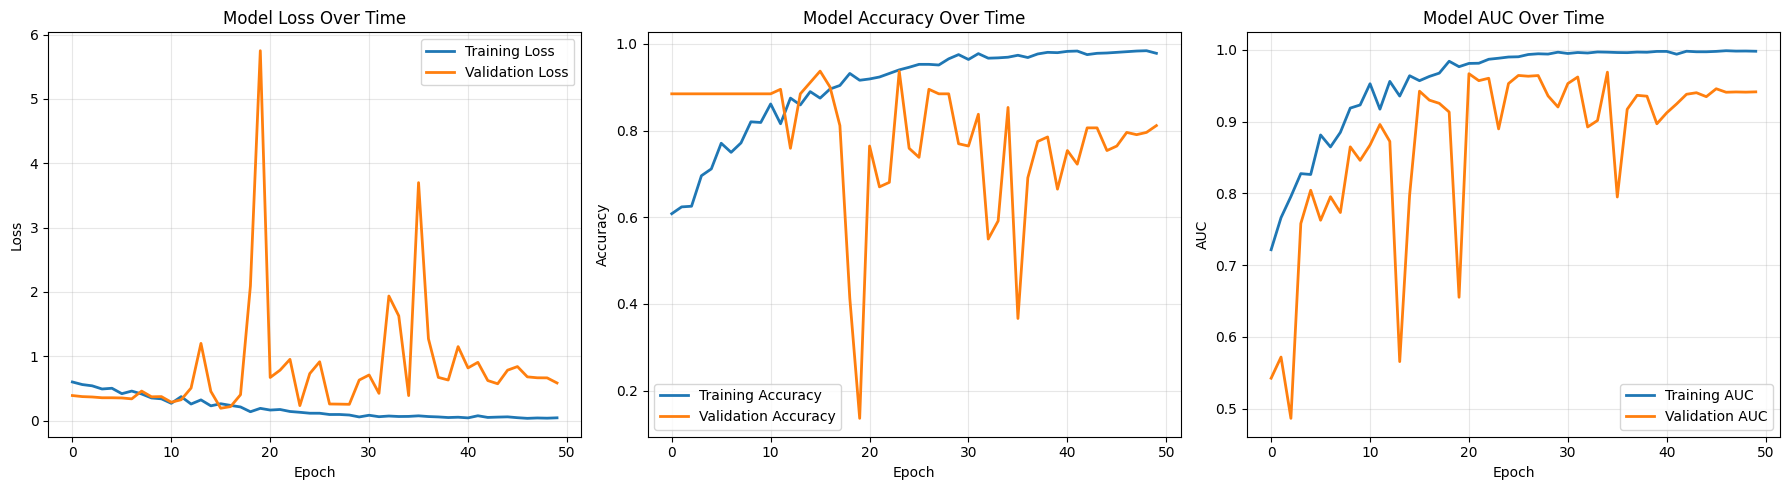

In [22]:
print("Starting full training session...")

# For GPU: can use float16 to save memory
# trainx_tensor = tf.cast(trainx_tensor, tf.float16) / 255.0
# valx_tensor = tf.cast(valx_tensor, tf.float16) / 255.0
# model = build_3d_cnn(input_shape=(28, 28, 28, 1), dropout_rate=0.3)
# model.compile(...) # recompile for float16

history_full = model.fit(
    trainx_norm, trainy_flat,
    batch_size=32,  # Larger batch for GPU
    epochs=100,  # Will stop early with callback
    validation_data=(valx_norm, valy_flat),
    class_weight=class_weight,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history_full.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history_full.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Model Loss Over Time')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history_full.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history_full.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Model Accuracy Over Time')
axes[1].legend()
axes[1].grid(alpha=0.3)

# AUC
axes[2].plot(history_full.history['auc'], label='Training AUC', linewidth=2)
axes[2].plot(history_full.history['val_auc'], label='Validation AUC', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].set_title('Model AUC Over Time')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()





MODEL EVALUATION ON TEST SET


2025-12-12 09:00:43.610220: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-12 09:00:43.610248: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-12 09:00:43.874552: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_170', 8 bytes spill stores, 8 bytes spill loads

2025-12-12 09:00:44.093901: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re


Test Loss: 0.3159
Test Accuracy: 0.8927
Test AUC: 0.9507

Classification Report:
              precision    recall  f1-score   support

     Healthy     0.9901    0.8879    0.9362       339
    Aneurysm     0.5128    0.9302    0.6612        43

    accuracy                         0.8927       382
   macro avg     0.7515    0.9091    0.7987       382
weighted avg     0.9364    0.8927    0.9053       382



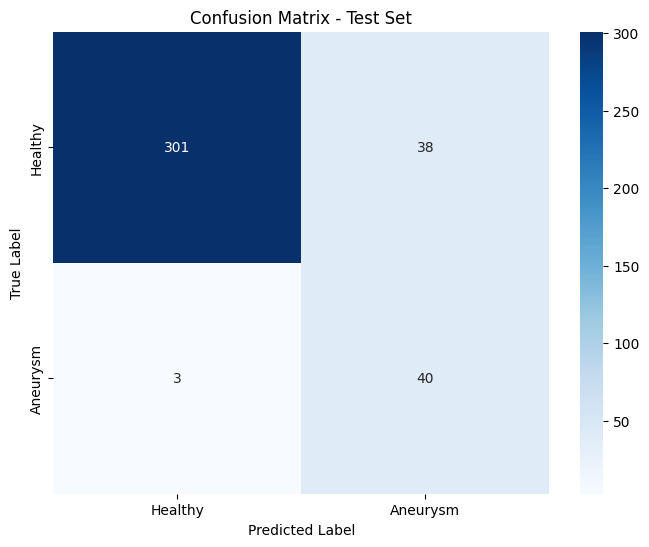

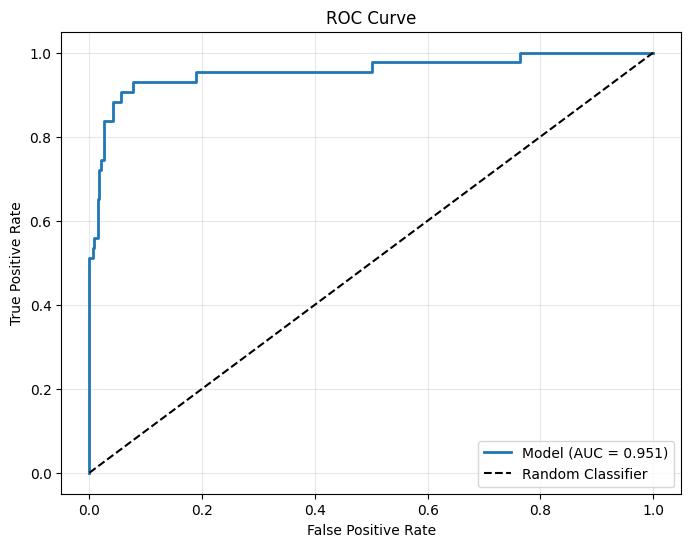

In [23]:


print("\n" + "="*70)
print("MODEL EVALUATION ON TEST SET")
print("="*70)

# Load best model
model = keras.models.load_model('best_vessel_model.h5')

# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(testx_norm, testy_flat, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Get predictions
y_pred_proba = model.predict(testx_norm, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, y_pred, 
                          target_names=['Healthy', 'Aneurysm'],
                          digits=4))

# Confusion matrix
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Aneurysm'],
            yticklabels=['Healthy', 'Aneurysm'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'Model (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [27]:

print("VesselMNIST3D Baseline Performance (from MedMNIST paper):")
print("- ResNet18 (3D): AUC ~0.920, ACC ~0.890")
print("- Auto-sklearn: AUC ~0.917, ACC ~0.887")
print("\nYour Model Performance:")
print(f"- Test AUC: {test_auc:.4f}")
print(f"- Test ACC: {test_acc:.4f}")

if test_auc >= 0.920:
    print("\nmodel matches or exceeds the baseline!")
elif test_auc >= 0.900:
    print("\n Good performance! Close to the baseline.")
else:
    print("\nRoom for improvement")
    

VesselMNIST3D Baseline Performance (from MedMNIST paper):
- ResNet18 (3D): AUC ~0.920, ACC ~0.890
- Auto-sklearn: AUC ~0.917, ACC ~0.887

Your Model Performance:
- Test AUC: 0.9507
- Test ACC: 0.8927

model matches or exceeds the baseline!
